In [1]:
import numpy as np
import sys
import time
import random
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pickle 

import torch
import torch.nn as nn
import torch.optim as optim

sys.path.append('/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm')

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from word2vec_eltdm.common import Tokenizer, VocabCreator, DataLoader, TokenCleaner, Preprocessor, Subsampler, evaluate, visualization_tsne
from word2vec_eltdm.word2vec_accelerated import PytorchNegWord2Vec, NegativeSamplingLoss, train_NSL, update_best_loss

## Get data and create vocab

In [3]:
datapath = "../data/text8.txt"

RATIO = 1
return_only_train = True
tokenizer = Tokenizer(datapath)
token_cleaner = TokenCleaner(freq_threshold=5)
vocab_creator = VocabCreator()
text8_dataset = Preprocessor(tokenizer, token_cleaner, vocab_creator, RATIO, return_only_train).preprocess()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
print("Size of our vocabulary:", len(text8_dataset.tokens_to_id))

Size of our vocabulary: 63492


In [5]:
print("Number of tokens in our train dataset:", len(text8_dataset.train_tokens))

Number of tokens in our train dataset: 10566033


In [6]:
print("Number of tokens in our val dataset:", len(text8_dataset.val_tokens))

Number of tokens in our val dataset: 0


In [7]:
print("Number of tokens in our test dataset:", len(text8_dataset.test_tokens))

Number of tokens in our test dataset: 0


## Subsampling of frequent words, as in Mikolov 2013.

In [8]:
subsampler = Subsampler(text8_dataset.train_tokens)
text8_dataset.train_tokens, text8_dataset.frequencies = subsampler.subsample()

In [9]:
print("Size of our vocabulary after subsampling of frequent words, for train:", len(text8_dataset.tokens_to_id))

Size of our vocabulary after subsampling of frequent words, for train: 63492


In [10]:
print("Number of tokens in train dataset:", len(text8_dataset.train_tokens))

Number of tokens in train dataset: 3767955


## DataLoader

In [11]:
window = 5
batch_size = 512
train_dataloader = DataLoader(text8_dataset, text8_dataset.train_tokens, window, batch_size)

## Model

In [12]:
# defining the parameters
len_vocab = len(text8_dataset.tokens_to_id)
embedding_size = 300
learning_rate = 0.003
n_samples = 5
epochs = 20

# Get our noise distribution
word_freqs = np.array(sorted(text8_dataset.frequencies.values(), reverse=True))
unigram_dist = word_freqs / word_freqs.sum()
noise_dist = unigram_dist ** (0.75) / np.sum(unigram_dist ** (0.75))

# instantiate the model
model = PytorchNegWord2Vec(
    len_vocab,
    embedding_size,
    noise_dist=noise_dist,
    device=device
).to(device)
model.initialize_weights()

criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [13]:
# train for some number of epochs

# takes about 1:03 minutes per epoch

train_loss_history = []
tbar = trange(epochs)

for epoch in tbar:
    print(f"###################### EPOCH {epoch} ###########################")
    
    train_loss = train_NSL(model, train_dataloader, criterion, optimizer, n_samples, device)
    print("Training loss:", train_loss.item())
    train_loss_history.append(train_loss.item())
    
    # Keep track of the best model
    update_best_loss(model, train_loss, device)
    
    embeddings = model.embedding_input.weight.data.detach().cpu().numpy()
    evaluate(embeddings, text8_dataset.id_to_tokens, nb_words=20)

  0%|          | 0/20 [00:00<?, ?it/s]

###################### EPOCH 0 ###########################


  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 14.5878
Current Training Loss 7.4252
Current Training Loss 4.91241
Current Training Loss 4.46735
Current Training Loss 4.31469
Training loss: 5.972482204437256
Now best model has 5.972482204437256 loss
Saving model
year | day, th, years, deaths, british
x | g, p, f, n, e
external | eight, examiner, com, two, nine
century | western, history, th, empire, ancient
links | nine, one, eight, zero, thomas
english | writer, b, john, one, german
would | still, also, however, individuals, case
states | united, city, national, council, union
united | national, states, president, government, member
series | season, record, one, released, eight
remaining | days, tenth, calendar, march, hieria
reached | peace, organizations, home, zef, course
animal | disintegration, suffers, kazakhstani, impedes, ethnologists
billion | growth, est, economy, gdp, economic
signed | united, treaty, local, soviet, federal
individuals | social, opposed, would, benefits, movement
hebrew | jewish, la

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 3.21609
Current Training Loss 2.80151
Current Training Loss 2.81194
Current Training Loss 2.82657
Current Training Loss 2.81073
Training loss: 2.8706729412078857
Now best model has 2.8706729412078857 loss
Saving model
century | centuries, th, medieval, modern, roman
would | saw, still, wanted, subsequently, could
example | mean, usually, object, word, kinds
english | writer, french, latin, john, composer
states | united, territory, located, florida, largest
known | near, part, called, three, name
like | called, simple, words, example, style
different | patterns, sounds, usually, corresponding, derived
much | large, another, made, mostly, borders
war | troops, military, invasion, soviet, army
wars | invasion, battles, empire, captured, began
computers | hardware, computer, pc, compatible, operating
medicine | prize, medical, physiology, chemistry, chemist
motion | moving, direction, solar, stars, event
translation | text, commentary, book, translated, texts
support

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.48265
Current Training Loss 2.34363
Current Training Loss 2.60301
Current Training Loss 2.48246
Current Training Loss 2.36839
Training loss: 2.496732473373413
Now best model has 2.496732473373413 loss
Saving model
history | links, ancient, geography, website, part
early | began, later, became, period, th
language | languages, spoken, dialect, vocabulary, grammar
different | sounds, also, patterns, sound, possible
also | use, including, used, various, different
name | language, referred, also, tv, called
well | many, created, mostly, particularly, occasionally
since | used, popular, thus, directly, recent
five | three, four, seven, six, eight
see | references, article, links, various, information
lack | serious, health, affected, regulation, growing
billion | exports, revenues, imports, gdp, usd
regarded | ideas, writings, conscious, however, scholars
table | symbol, numbers, tables, unicode, used
internal | phases, directly, pressure, stored, tube
response | res

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.34213
Current Training Loss 2.2238
Current Training Loss 2.50727
Current Training Loss 2.283
Current Training Loss 2.2464
Training loss: 2.3588645458221436
Now best model has 2.3588645458221436 loss
Saving model
time | longer, also, could, messages, much
several | also, known, alongside, called, include
would | never, able, wanted, saw, way
see | references, article, external, website, list
based | using, used, also, version, use
may | used, two, certain, cases, similar
country | economy, demographics, relations, government, republic
list | see, topics, links, lists, official
also | based, including, used, use, various
united | states, presidents, international, community, alabama
clear | difficult, cases, arising, larger, makes
round | rounds, lost, straight, championship, scoring
computers | hardware, computer, machines, microcomputers, disk
province | region, provinces, south, provincial, regions
ship | ships, sail, cruiser, boats, navy
medicine | physiology,

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.24059
Current Training Loss 2.17036
Current Training Loss 2.49417
Current Training Loss 2.1943
Current Training Loss 2.15229
Training loss: 2.2773938179016113
Now best model has 2.2773938179016113 loss
Saving model
states | united, people, bureau, state, virginia
language | languages, vocabulary, words, spoken, dialect
year | years, march, days, month, five
de | la, le, french, du, des
new | york, boston, first, two, seven
system | systems, operating, unix, programs, bsd
high | low, level, levels, speed, used
number | numbers, full, use, least, value
state | democratic, republic, legislature, states, located
years | year, age, male, birth, female
appointed | elected, ministers, minister, chief, appoints
reading | bibliography, letters, reader, text, dictionary
supported | support, software, development, windows, lacked
consider | neither, expresses, say, shafi, justification
conflict | lebanon, guerrilla, withdrew, arab, palestinians
martin | peter, luther, john

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.15787
Current Training Loss 2.07695
Current Training Loss 2.44015
Current Training Loss 2.1532
Current Training Loss 2.12321
Training loss: 2.2193989753723145
Now best model has 2.2193989753723145 loss
Saving model
common | sometimes, used, usually, different, commonly
c | f, g, x, b, e
american | actor, singer, actress, musician, nine
would | could, continue, demanded, upon, get
state | national, states, government, democratic, legislature
f | c, g, quad, e, n
de | la, le, du, ois, en
eight | one, three, six, seven, four
english | welsh, poet, french, composer, england
first | one, year, new, zero, later
temperature | temperatures, melting, heat, thermal, celsius
sold | company, sales, marketed, version, sell
sexual | intercourse, homosexual, heterosexual, sexuality, sexually
committee | chairman, commission, congress, council, november
motion | picture, angular, moving, experiment, frame
consider | believe, true, infinite, function, views
ed | routledge, isbn,

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.13447
Current Training Loss 2.03113
Current Training Loss 2.47632
Current Training Loss 2.11976
Current Training Loss 2.00148
Training loss: 2.175774335861206
Now best model has 2.175774335861206 loss
Saving model
south | north, east, west, region, africa
game | games, played, play, players, gameplay
zero | two, eight, one, six, three
although | many, also, generally, including, usually
n | f, p, v, sum, rightarrow
modern | century, traditional, western, today, similar
new | york, two, one, first, zero
number | numbers, n, million, least, known
links | external, page, site, references, website
american | actor, actress, musician, singer, nine
calendar | gregorian, leap, calendars, intercalary, proleptic
ed | routledge, isbn, press, pp, vol
sold | sales, company, version, manufactured, sale
conflict | violence, political, israel, israeli, terrorism
kind | sense, words, forms, heteroatom, nothing
users | software, user, windows, use, internet
purpose | machine, ab

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.07921
Current Training Loss 2.01441
Current Training Loss 2.43261
Current Training Loss 2.09148
Current Training Loss 2.03405
Training loss: 2.1402158737182617
Now best model has 2.1402158737182617 loss
Saving model
second | third, followed, fifth, first, fourth
e | g, p, c, n, f
form | formed, called, forms, also, see
history | links, see, press, external, historical
many | although, among, especially, well, different
state | states, country, government, union, vested
five | four, three, seven, two, six
different | various, changes, usually, many, often
common | sometimes, forms, different, terminology, e
eight | one, seven, nine, six, zero
environment | environmental, pollution, soil, biodiversity, effluents
noted | philosophy, regarding, leonard, excellent, method
temperature | thermal, temperatures, heat, celsius, kelvins
performed | performing, perform, stage, solo, songs
values | value, variables, defined, integer, tuples
wars | war, fought, victorious, re

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.06738
Current Training Loss 1.94718
Current Training Loss 2.40535
Current Training Loss 2.00291
Current Training Loss 1.95265
Training loss: 2.111999988555908
Now best model has 2.111999988555908 loss
Saving model
government | party, political, parliament, economic, democratic
th | century, centuries, year, eight, seven
several | still, various, also, created, many
city | area, town, located, cities, urban
people | living, births, many, activists, cities
life | book, wrote, lived, children, lives
early | late, century, later, began, th
see | references, external, article, list, links
german | austrian, von, polish, composer, nazi
like | using, sometimes, called, although, based
noted | denying, leonard, occasional, compared, thought
sold | selling, produced, sales, market, company
performed | performing, concert, perform, musical, stage
electric | acoustic, guitar, electrical, magnetic, voltage
chicago | philadelphia, illinois, university, dallas, angeles
motion

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 1.99659
Current Training Loss 1.93425
Current Training Loss 2.37124
Current Training Loss 1.97449
Current Training Loss 1.91133
Training loss: 2.088480234146118
Now best model has 2.088480234146118 loss
Saving model
year | years, march, five, january, two
zero | two, four, five, one, eight
system | systems, operating, multi, development, used
n | e, sum, p, r, log
work | published, wrote, working, worked, works
use | used, users, using, available, also
state | government, states, union, legislature, established
seven | five, six, eight, one, four
second | third, fourth, first, followed, half
name | originally, named, referred, etymology, called
speaking | language, speakers, speak, spoken, official
miles | km, river, mile, hills, situated
animal | animals, insects, human, humans, dogs
comes | word, usually, etymology, use, meaning
hebrew | tanakh, talmud, jewish, yiddish, biblical
acts | terrorism, group, offenses, convicted, bound
signed | ratified, treaty, ratif

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.0375
Current Training Loss 1.87648
Current Training Loss 2.3651
Current Training Loss 2.00155
Current Training Loss 1.96119
Training loss: 2.0693347454071045
Now best model has 2.0693347454071045 loss
Saving model
x | os, z, p, k, v
language | languages, dialects, spoken, dialect, words
city | cities, urban, town, area, metro
became | remained, early, known, soon, moved
german | austrian, polish, germany, hungarian, von
external | links, com, references, website, two
long | short, would, longer, possible, become
people | living, united, states, births, many
zero | two, six, one, four, five
c | f, e, b, g, seven
ad | bc, camulodunum, reign, invasions, roman
worked | work, spent, returned, started, moved
station | stations, radio, broadcast, broadcasting, fm
remaining | gregorian, leap, days, calendar, day
medicine | physician, physiology, nobel, medical, recipient
composer | musician, physicist, violinist, actor, singer
individuals | societies, individual, famili

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.04524
Current Training Loss 1.93454
Current Training Loss 2.3322
Current Training Loss 1.97653
Current Training Loss 1.88569
Training loss: 2.0530917644500732
Now best model has 2.0530917644500732 loss
Saving model
music | musical, musicians, genres, recordings, folk
number | numbers, base, set, product, although
early | probably, century, began, late, period
life | book, father, living, wrote, fiction
another | first, required, appears, unlike, full
part | area, east, region, formed, parts
although | many, almost, considered, certain, generally
much | using, large, significant, many, different
external | links, references, com, website, listing
also | several, see, external, considered, outside
round | rounds, playoffs, cartridge, lost, plating
province | provinces, region, capital, administrative, annexed
response | responses, respond, inevitable, interfere, feedback
billion | exports, imports, revenues, reserves, gdp
centuries | century, th, period, medieval,

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.0367
Current Training Loss 1.89001
Current Training Loss 2.30722
Current Training Loss 1.95975
Current Training Loss 1.89336
Training loss: 2.0395381450653076
Now best model has 2.0395381450653076 loss
Saving model
used | use, commonly, using, systems, multiple
years | year, age, birth, female, five
e | g, c, n, f, l
language | languages, spoken, dialect, vocabulary, dialects
x | v, os, k, beta, p
th | century, centuries, one, early, year
new | york, first, press, zero, two
world | history, worldwide, war, coming, us
see | article, links, list, external, history
king | throne, son, henry, queen, brother
electric | electrical, magnetic, electronic, amp, dipole
remain | although, farm, eased, including, regions
christianity | religions, christian, religion, christians, belief
evolution | evolutionary, darwin, creationism, darwinian, meme
ad | bc, empire, centuries, quadi, ce
sets | set, subsets, countably, bigcup, subset
purpose | isa, machine, instruction, based,

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.0093
Current Training Loss 1.86209
Current Training Loss 2.28893
Current Training Loss 1.92952
Current Training Loss 1.86951
Training loss: 2.027172565460205
Now best model has 2.027172565460205 loss
Saving model
state | government, states, republic, union, territories
people | living, cities, members, states, largest
u | united, us, states, highway, open
one | four, nine, six, eight, seven
first | one, eight, new, created, became
university | institute, college, universities, press, cambridge
king | queen, throne, duke, conqueror, henry
new | york, first, one, press, two
united | states, kingdom, u, nations, president
life | work, wrote, book, years, death
sets | set, countably, subsets, nonempty, subset
purpose | machine, purposes, instructions, incapable, special
beyond | universe, created, understanding, existed, principles
flight | flew, boeing, flights, aircraft, airlines
sexual | intercourse, homosexual, sexually, heterosexual, sex
ed | isbn, press, pp, e

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 1.98727
Current Training Loss 1.90693
Current Training Loss 2.29711
Current Training Loss 1.94719
Current Training Loss 1.91001
Training loss: 2.0177481174468994
Now best model has 2.0177481174468994 loss
Saving model
french | fran, ois, english, seven, pierre
known | called, name, early, included, referred
set | sets, defined, mandelbrot, subset, complete
often | frequently, typically, example, sometimes, less
time | period, events, saw, earlier, months
later | early, became, son, late, chose
example | specific, using, similar, often, particular
nine | one, seven, four, eight, six
city | cities, area, town, urban, capital
american | actor, nine, singer, actress, musician
wars | war, armies, invasion, fought, battle
sets | set, countably, subsets, disjoint, bijection
remain | forced, within, closer, soft, tensions
physics | physicists, quantum, planck, mechanics, studying
labour | party, unions, labor, parties, socialist
hebrew | tanakh, tiberian, sephardim, bible

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 1.98372
Current Training Loss 1.89816
Current Training Loss 2.32304
Current Training Loss 1.93302
Current Training Loss 1.85266
Training loss: 2.0087788105010986
Now best model has 2.0087788105010986 loss
Saving model
state | union, states, established, legislature, located
th | century, centuries, rd, year, st
name | early, named, meaning, names, refer
modern | century, evolved, different, developed, history
number | numbers, except, integer, set, n
see | article, links, references, external, list
well | many, various, based, produced, generally
many | although, different, including, others, considered
six | four, five, three, one, seven
three | six, four, two, zero, five
ethnic | ethnically, minorities, ethnicity, population, nationality
kind | know, seen, sake, reflective, often
brown | gray, gordon, andrews, blue, american
convention | conventions, international, polk, geneva, amendment
environment | environmental, climate, activities, desertification, biodive

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 1.97962
Current Training Loss 1.93917
Current Training Loss 2.3049
Current Training Loss 1.8982
Current Training Loss 1.86308
Training loss: 2.0016989707946777
Now best model has 2.0016989707946777 loss
Saving model
de | la, du, le, sur, en
eight | six, one, nine, seven, zero
six | three, eight, one, four, two
b | politician, writer, composer, seven, eight
form | called, forms, like, derived, usually
made | also, make, later, since, producing
example | similar, case, often, uses, mean
g | e, f, c, r, k
could | able, would, enough, time, although
years | year, march, age, male, female
station | stations, radio, broadcast, railway, cable
ad | bc, empire, saccas, quadi, romans
ethnic | minorities, ethnically, nationality, peoples, ethnicity
convention | conventions, signed, berne, treaty, international
sir | john, william, robert, minister, seven
kind | particular, practiced, works, notion, sense
consider | simply, infinite, true, definition, sin
animal | animals, ca

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 2.01871
Current Training Loss 1.9335
Current Training Loss 2.28917
Current Training Loss 1.8938
Current Training Loss 1.88094
Training loss: 1.9946180582046509
Now best model has 1.9946180582046509 loss
Saving model
system | systems, operating, unix, computer, using
years | age, male, female, year, population
although | many, almost, since, serious, alongside
long | like, earlier, old, period, double
called | often, form, like, time, name
king | throne, kings, queen, henry, brother
war | troops, army, forces, civil, battle
based | version, various, using, systems, versions
work | published, life, book, wrote, contemporary
zero | two, three, one, nine, six
write | read, authors, written, languages, literacy
sex | male, sexually, sexual, female, women
consider | true, furthermore, simply, considered, function
table | tables, array, contents, arrays, hash
summer | winter, spring, winters, snowfall, autumn
places | entrance, grave, mosques, conceded, hamlets
clear | w

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 1.95941
Current Training Loss 1.91448
Current Training Loss 2.2407
Current Training Loss 1.93878
Current Training Loss 1.84378
Training loss: 1.9892579317092896
Now best model has 1.9892579317092896 loss
Saving model
g | e, f, r, c, b
early | late, began, ages, became, continued
although | many, considered, almost, since, like
nine | one, eight, seven, zero, six
may | occur, symptoms, often, two, syncope
seven | one, six, five, three, four
later | early, friend, wrote, began, decided
also | used, famous, many, history, early
often | typically, sometimes, include, frequently, example
work | published, wrote, one, life, research
brown | black, green, gray, trevor, lemurs
border | bordered, river, rivers, mountains, southwest
consider | simply, regard, positive, faith, problems
agreement | negotiated, signed, diplomatic, agreements, treaty
ed | press, isbn, pp, routledge, eds
paper | pulp, printed, acidic, vetoes, society
multiple | allowing, uses, single, based, imp

  0%|          | 0/7360 [00:00<?, ?it/s]

Current Training Loss 1.92125
Current Training Loss 1.89229
Current Training Loss 2.25421
Current Training Loss 1.85101
Current Training Loss 1.81387
Training loss: 1.983805775642395
Now best model has 1.983805775642395 loss
Saving model
world | war, europe, nine, largest, nations
history | links, article, external, see, topics
could | requiring, able, without, enough, longer
u | states, us, uss, open, united
however | contrary, would, failure, despite, say
early | began, late, century, later, became
modern | century, medieval, today, innovations, classical
government | democratic, party, legislative, parliament, governments
known | became, famous, name, derived, actually
major | minor, particularly, cities, league, baseball
ad | bc, inscriptions, empire, invaded, dynasties
flight | spacecraft, boeing, aircraft, airlines, air
hebrew | tanakh, tiberian, vowel, arabic, aramaic
brown | black, andrews, american, lemurs, anderson
table | tables, hiragana, represent, array, char
lack | due, 

## Evaluation on the task of word similarities

In [15]:
filepath = "../word2vec_eltdm/models/PytorchNegWord2Vec_1.983805775642395.p"
with open(filepath, "rb") as file:
    model = pickle.load(file)

In [16]:
model = model["PytorchNegWord2Vec"]
embeddings = model.embedding_input.weight.data.numpy()

### Evaluate using cosine similarity

In [17]:
evaluate(embeddings, text8_dataset.id_to_tokens, nb_words=20)

power | regime, influence, powers, rule, actions
time | using, since, systems, created, events
became | began, soon, wife, early, established
university | institute, college, universities, press, colleges
british | english, actor, american, canadian, britain
n | p, r, quad, sum, pi
state | government, union, political, legislative, constitution
could | requiring, able, without, enough, longer
south | north, east, africa, southwest, river
th | century, centuries, seven, st, rd
environment | environmental, habitat, biodiversity, pollution, virtual
round | rounds, ammunition, playoffs, winner, fire
billion | exports, imports, reserves, million, exporter
www | http, htm, com, org, edu
faith | christianity, adherents, belief, arminians, worship
martin | luther, peter, isbn, jr, richard
kind | particular, tells, traditions, know, fancy
flight | spacecraft, boeing, aircraft, airlines, air
climate | humid, drier, coastal, subtropical, temperatures
approximately | km, inches, due, metres, maxim

### t-SNE embedding visualisation

/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kaliayev/Documents/ENSAE/elements_logiciels/word2vec_eltdm/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


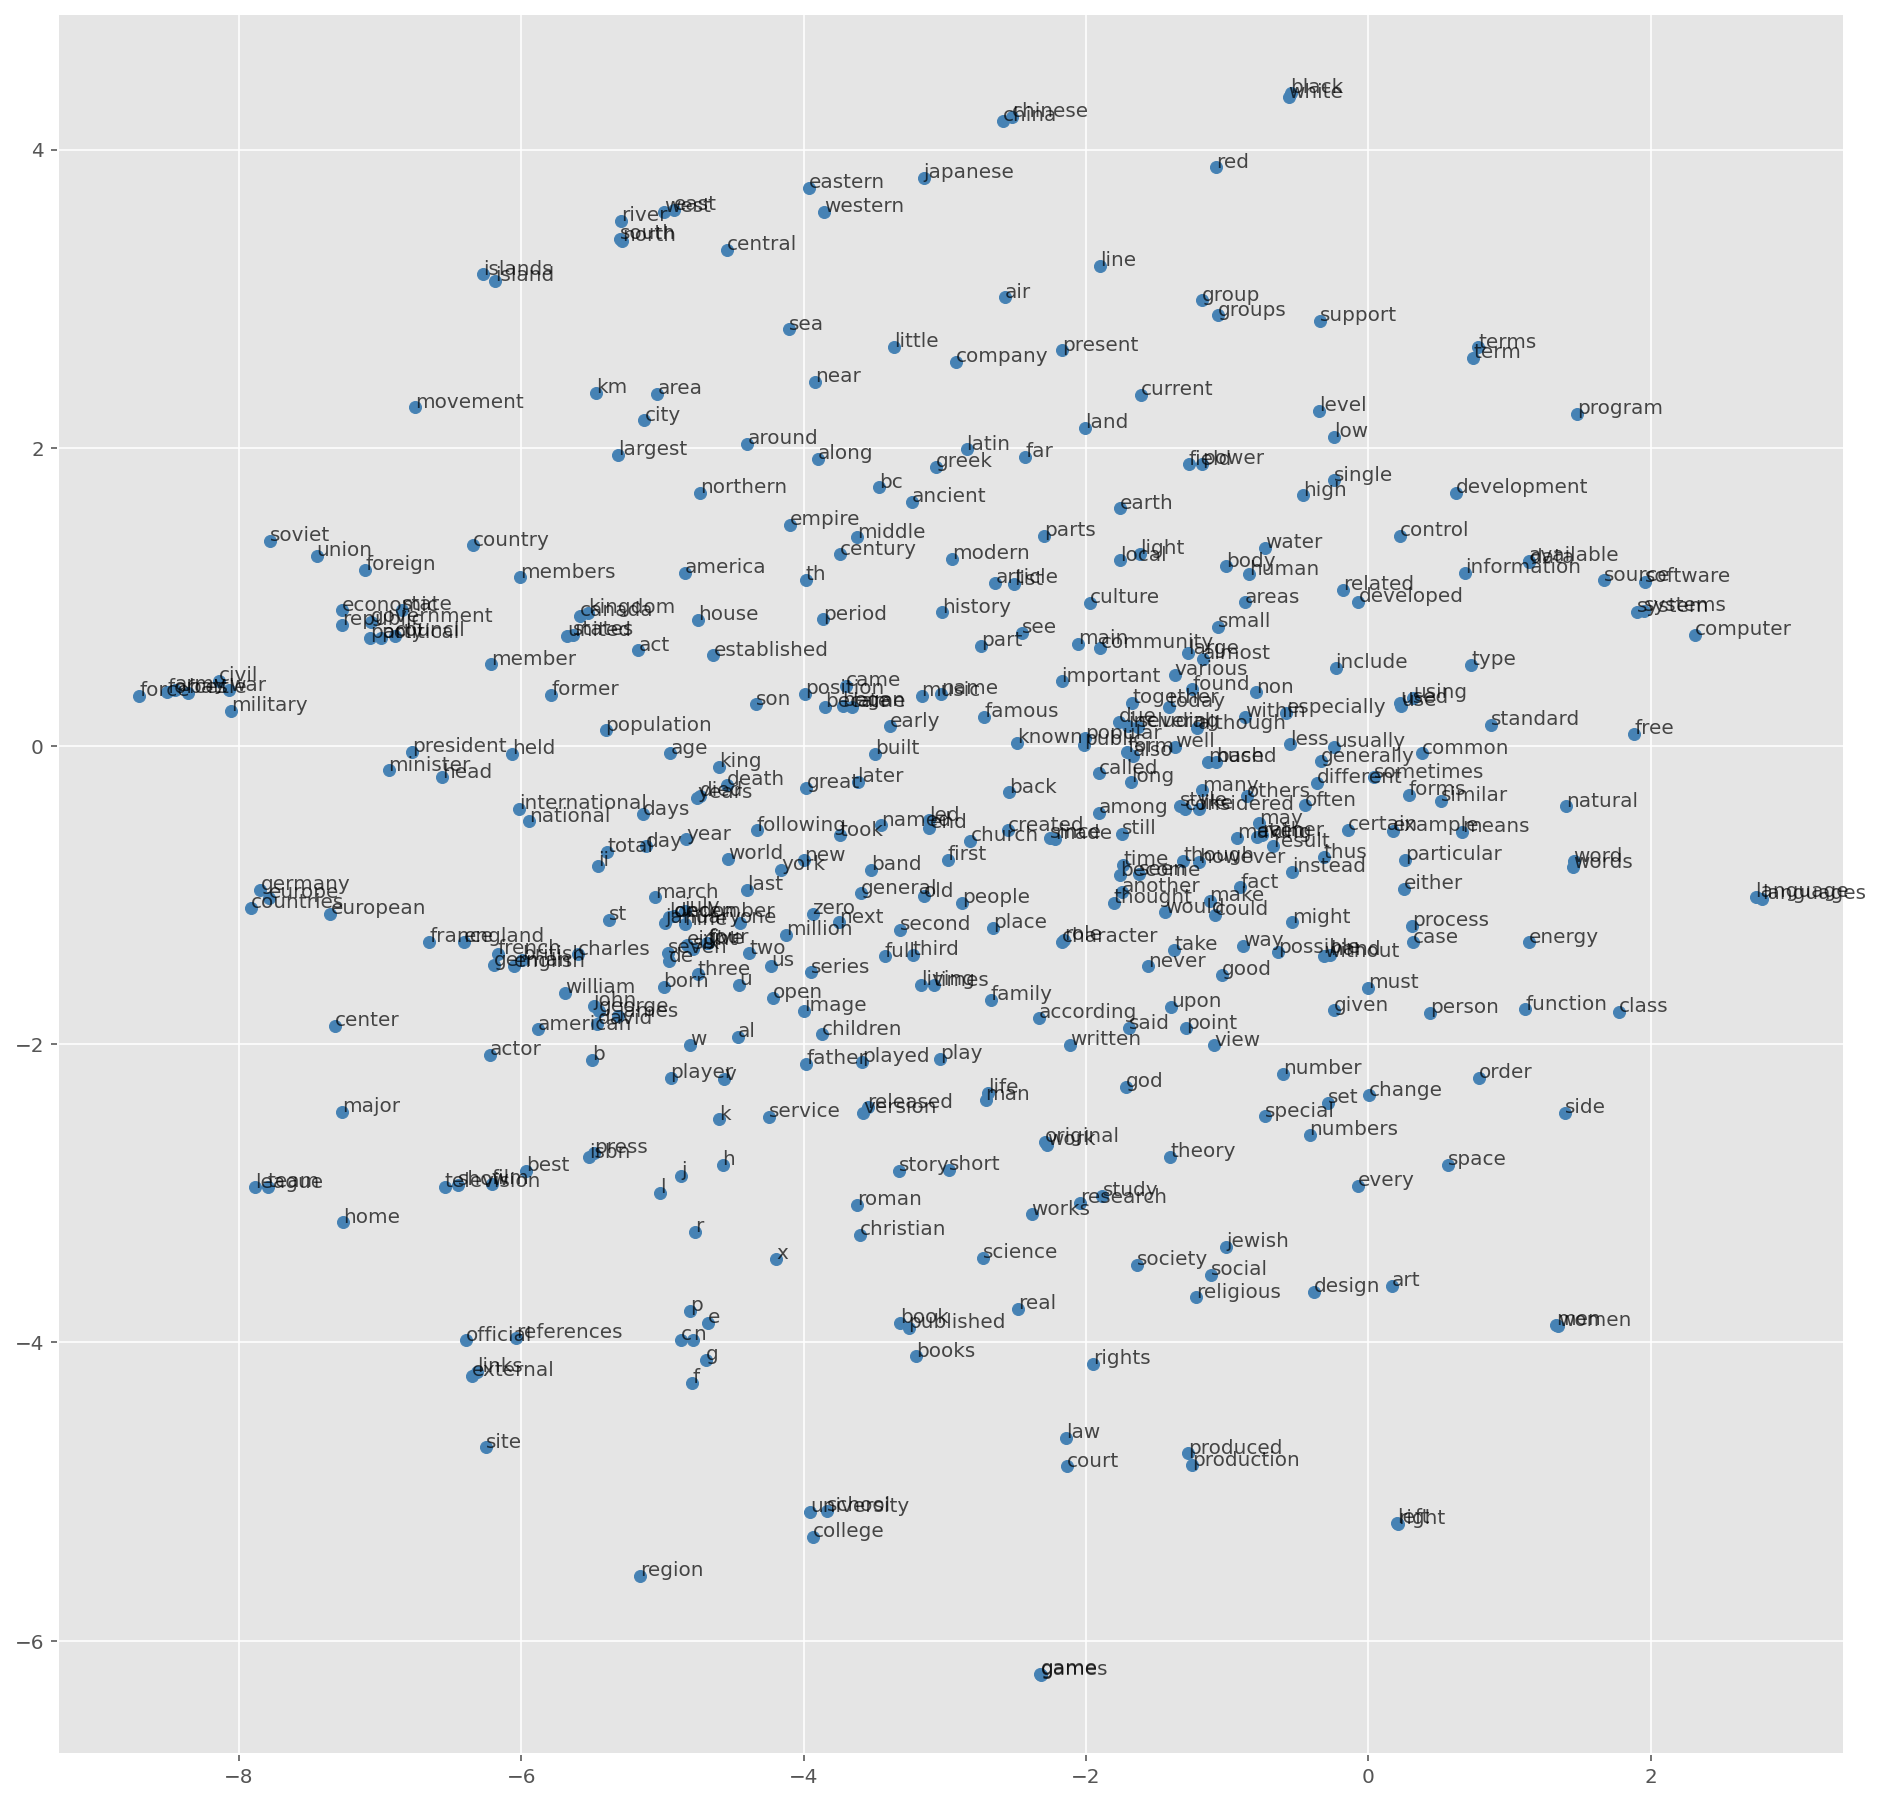

In [18]:
visualization_tsne(embeddings, text8_dataset.id_to_tokens, nb_words = 400)